In [77]:
# !pip3 install bayesian-optimization

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn import metrics as skmetrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from bayes_opt import BayesianOptimization

In [79]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
sns.set(rc={'figure.figsize':(5,10)})


In [80]:
X_smote = pd.read_csv('data/X_smote.csv')
y_smote = pd.read_csv('data/y_smote.csv')

X_val = pd.read_csv('data/X_val.csv')
y_val = pd.read_csv('data/y_val.csv')

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv')

In [81]:
def print_statistics(y_actual, y_pred, y_pred_prob, dataset_type):
  print(f"====================={dataset_type}====================")
  print(f"accuracy: {round(skmetrics.accuracy_score(y_actual, y_pred),5)}")
  print(f"precision: {round(skmetrics.precision_score(y_actual, y_pred),5)}")
  print(f"recall: {round(skmetrics.recall_score(y_actual, y_pred),5)}")
  print(f"f1 score: {round(skmetrics.f1_score(y_actual, y_pred),5)}")
  prec, recall, thresholds = skmetrics.precision_recall_curve(y_actual, y_pred_prob)
  print(f'pr auc: {round(skmetrics.auc(recall, prec), 5)}')


## Random Forest

In [82]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_smote, y_smote)

y_pred_train = rf_model.predict(X_smote)
y_pred_train_proba = rf_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = rf_model.predict(X_val)
y_pred_val_proba = rf_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = rf_model.predict(X_test)
y_pred_test_proba = rf_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2399065869.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = rf.fit(X_smote, y_smote)


=====================train====================
accuracy: 1.0
precision: 1.0
recall: 1.0
f1 score: 1.0
pr auc: 1.0
=====================val====================
accuracy: 0.92815
precision: 0.91317
recall: 0.81105
f1 score: 0.85909
pr auc: 0.87481
=====================test====================
accuracy: 0.92051
precision: 0.92558
recall: 0.76735
f1 score: 0.83907
pr auc: 0.86478


## Extra Trees Classifier

In [83]:
xtc = ExtraTreesClassifier()
xtc_model = xtc.fit(X_smote, y_smote)

y_pred_train = xtc_model.predict(X_smote)
y_pred_train_proba = xtc_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = xtc_model.predict(X_val)
y_pred_val_proba = xtc_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = xtc_model.predict(X_test)
y_pred_test_proba = xtc_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/433721700.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


=====================train====================
accuracy: 1.0
precision: 1.0
recall: 1.0
f1 score: 1.0
pr auc: 1.0
=====================val====================
accuracy: 0.91913
precision: 0.8955
recall: 0.79306
f1 score: 0.84117
pr auc: 0.86337
=====================test====================
accuracy: 0.91739
precision: 0.91411
recall: 0.76607
f1 score: 0.83357
pr auc: 0.86402


## Tune the ExtraTrees classifier

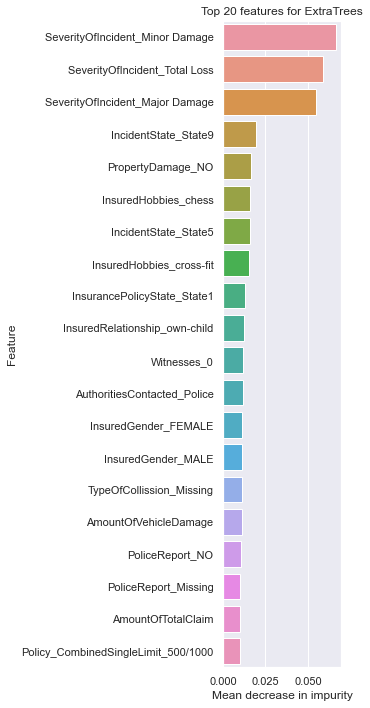

In [84]:
feature_names = [f"{X_smote.columns[i]}" for i in range(X_smote.shape[1])]

importances = xtc_model.feature_importances_

forest_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': importances}
                                    )
forest_importances = forest_importances.sort_values('importance', ascending=False)
forest_importances = forest_importances[:20] # top 20

fig, ax = plt.subplots(1,1)
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(y='feature', x='importance', ax=ax, data=forest_importances, orient="h")
ax.set_title("Top 20 features for ExtraTrees")
ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("Feature")
fig.tight_layout()

## Bayesian optimization of ExtraTrees for hyperparameter tuning

In [85]:
seed = 1

def extratrees(n_estimators,
                max_depth,
                min_samples_split,
                min_samples_leaf,
                max_features,
                bootstrap):

    n_estimators = int(n_estimators)
    max_depth = int(max_depth) # Pre-pruning technique
    min_samples_split = int(min_samples_split) # Pre-pruning technique
    min_samples_leaf = int(min_samples_leaf) # Pre-pruning technique
    bootstrap = bootstrap > 0.5
    
    assert type(n_estimators) == int
    assert type(max_depth) == int
    assert type(min_samples_split) == int
    assert type(min_samples_leaf) == int


    xtc = ExtraTreesClassifier(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               bootstrap=bootstrap,
                               oob_score=bootstrap,
                               n_jobs=6,
                               random_state=seed,
                               verbose=0)

    xtc_model = xtc.fit(X_smote, y_smote)
    # use validation set to evaluate performance - F1 is our main metric
    y_pred_val = xtc_model.predict(X_val)
    return skmetrics.f1_score(y_val, y_pred_val)

In [86]:
# space to search
# params = {'n_estimators': (25, 251),
params = {'n_estimators': (25, 150),
          'max_depth' : (10, 200),
          'min_samples_split': (2,15),
          'min_samples_leaf' : (2,15),
          'max_features' : (.2,.8),
          'bootstrap':(0,1),
          } 

xtcBO = BayesianOptimization(extratrees, 
                            pbounds = params, 
                            random_state = seed)

print(xtcBO.space.keys)

['bootstrap', 'max_depth', 'max_features', 'min_samples_leaf', 'min_samples_split', 'n_estimators']


In [87]:
xtcBO.maximize(init_points=6, 
               n_iter=25,
               acq = 'ucb',
               xi = 0.0,
               alpha = 1e-6)

|   iter    |  target   | bootstrap | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 1         | 0.8224    | 0.417     | 146.9     | 0.2001    | 5.93      | 3.908     | 36.54     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 2         | 0.8081    | 0.1863    | 75.66     | 0.4381    | 9.005     | 7.45      | 110.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 3         | 0.8081    | 0.2045    | 176.8     | 0.2164    | 10.72     | 7.425     | 94.84     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 4         | 0.7891    | 0.1404    | 47.64     | 0.6804    | 14.59     | 6.075     | 111.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 5         | 0.831     | 0.8764    | 180.0     | 0.251     | 2.508     | 4.208     | 134.8     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 6         | 0.804     | 0.09835   | 90.01     | 0.7747    | 8.931     | 10.99     | 64.44     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 7         | 0.8262    | 0.3821    | 178.8     | 0.6073    | 2.65      | 5.49      | 136.2     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 8         | 0.8094    | 1.0       | 186.2     | 0.2       | 5.421     | 2.0       | 128.1     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 9         | 0.8351    | 0.9724    | 177.8     | 0.7025    | 2.235     | 2.904     | 131.4     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 10        | 0.8185    | 0.3977    | 170.0     | 0.3152    | 6.482     | 3.172     | 131.1     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 11        | 0.827     | 1.0       | 177.4     | 0.2       | 2.0       | 9.367     | 128.0     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 12        | 0.8072    | 0.8158    | 156.7     | 0.4926    | 5.4       | 6.618     | 27.69     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 13        | 0.8229    | 0.6098    | 174.1     | 0.7616    | 3.625     | 3.611     | 119.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 14        | 0.8168    | 0.3659    | 135.6     | 0.7474    | 3.227     | 2.259     | 40.93     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 15        | 0.8186    | 1.0       | 169.5     | 0.8       | 2.0       | 15.0      | 120.4     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 16        | 0.7907    | 0.7425    | 149.8     | 0.6895    | 10.45     | 5.643     | 46.29     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 17        | 0.8081    | 0.0975    | 138.9     | 0.2622    | 8.297     | 5.997     | 28.49     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 18        | 0.8075    | 1.0       | 178.0     | 0.8       | 7.719     | 5.06      | 131.0     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 19        | 0.8287    | 0.66      | 170.2     | 0.4409    | 2.181     | 7.653     | 128.6     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 20        | 0.8209    | 1.0       | 171.7     | 0.2       | 2.0       | 13.51     | 132.6     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 21        | 0.8348    | 0.9336    | 162.9     | 0.7052    | 2.931     | 3.626     | 120.0     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 22        | 0.8407    | 0.4036    | 160.6     | 0.2       | 2.0       | 5.819     | 125.8     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 23        | 0.8162    | 0.1635    | 153.9     | 0.4492    | 7.081     | 7.089     | 125.6     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 24        | 0.8268    | 1.0       | 163.8     | 0.8       | 2.0       | 2.0       | 126.3     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 25        | 0.8384    | 0.0       | 162.1     | 0.2       | 2.0       | 9.372     | 122.7     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 26        | 0.8265    | 0.4922    | 158.8     | 0.6554    | 2.885     | 5.787     | 115.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 27        | 0.8232    | 0.04457   | 162.0     | 0.6519    | 5.947     | 9.714     | 127.3     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 28        | 0.7997    | 0.0       | 165.0     | 0.2       | 11.58     | 2.0       | 114.5     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 29        | 0.8322    | 0.3448    | 158.8     | 0.2486    | 3.032     | 6.024     | 139.2     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 30        | 0.8358    | 0.56      | 155.1     | 0.2       | 2.0       | 2.0       | 146.1     |


/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/2021403616.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_model = xtc.fit(X_smote, y_smote)


| 31        | 0.8375    | 0.0       | 154.3     | 0.2       | 2.0       | 10.29     | 147.1     |


In [88]:
# Best Hyperparameters selected
xtcBO.max

{'target': 0.8406779661016949,
 'params': {'bootstrap': 0.40360102731211306,
  'max_depth': 160.59234764518655,
  'max_features': 0.2,
  'min_samples_leaf': 2.0,
  'min_samples_split': 5.819074468474303,
  'n_estimators': 125.78270526494637}}

In [89]:
xtc_tuned = ExtraTreesClassifier(n_estimators = int(xtcBO.max['params']['n_estimators']),
                                    max_depth = int(xtcBO.max['params']['max_depth']),
                                    min_samples_split = int(xtcBO.max['params']['min_samples_split']),  
                                    min_samples_leaf = int(xtcBO.max['params']['min_samples_leaf']),
                                    max_features =  xtcBO.max['params']['max_features'],                 
                                    bootstrap = xtcBO.max['params']['bootstrap'] > 0.5,
                                    oob_score = xtcBO.max['params']['bootstrap'] > 0.5,
                                    n_jobs=6)

xtc_tuned_model = xtc_tuned.fit(X_smote, y_smote)

y_pred_train = xtc_tuned_model.predict(X_smote)
y_pred_train_proba = xtc_tuned_model.predict_proba(X_smote)[:, 1]
print_statistics(y_smote, y_pred_train, y_pred_train_proba, 'train')

y_pred_val = xtc_tuned_model.predict(X_val)
y_pred_val_proba = xtc_tuned_model.predict_proba(X_val)[:, 1]
print_statistics(y_val, y_pred_val, y_pred_val_proba, 'val')

y_pred_test = xtc_tuned_model.predict(X_test)
y_pred_test_proba = xtc_tuned_model.predict_proba(X_test)[:, 1]
print_statistics(y_test, y_pred_test, y_pred_test_proba, 'test')

/var/folders/nj/qv4q4t0d0yz8924lwlb0b73c0000gn/T/ipykernel_8569/1080922815.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  xtc_tuned_model = xtc_tuned.fit(X_smote, y_smote)


=====================train====================
accuracy: 0.99441
precision: 0.99731
recall: 0.9915
f1 score: 0.9944
pr auc: 0.99994
=====================val====================
accuracy: 0.91704
precision: 0.88555
recall: 0.79563
f1 score: 0.83819
pr auc: 0.85706
=====================test====================
accuracy: 0.91357
precision: 0.90137
recall: 0.7635
f1 score: 0.82672
pr auc: 0.86032
